In [1]:
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

In [2]:
BASE_DIR = "./../data/raw/BTCUSDT"
PROCESSED_DIR = "./../data/processed/BTCUSDT"

In [4]:
d = pd.read_csv("./../data/raw/BTCUSDT/1m/BTCUSDT_1m_0.csv")
d.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25601 entries, 0 to 25600
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   timestamp                        25601 non-null  object 
 1   open                             25601 non-null  float64
 2   high                             25601 non-null  float64
 3   low                              25601 non-null  float64
 4   close                            25601 non-null  float64
 5   volume                           25601 non-null  float64
 6   close_time                       25601 non-null  int64  
 7   quote_asset_volume               25601 non-null  float64
 8   number_of_trades                 25601 non-null  int64  
 9   taker_buy_base_asset_volume      25601 non-null  float64
 10  taker_buy_quote_asset_volume     25601 non-null  float64
 11  ignore                           25601 non-null  int64  
 12  1m_close_time     

In [134]:
def get_subdirectories_with_files(root_folder):
    result_dict = {}
    for dir_name in os.listdir(root_folder):
        dir_path = os.path.join(root_folder, dir_name)
        if os.path.isdir(dir_path):
            files_list = [file_name for file_name in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, file_name))]
            result_dict[dir_name] = files_list
    return result_dict

In [200]:
def create_path(base_dir,interval,filename):
    return os.path.join(base_dir,interval,filename)

In [139]:
data_pathes_dict = get_subdirectories_with_files(BASE_DIR)
intervals = list(data_pathes_dict.keys())
data_pathes_dict

{'12h': ['BTCUSDT_12h_0.csv'],
 '15m': ['BTCUSDT_15m_0.csv',
  'BTCUSDT_15m_1.csv',
  'BTCUSDT_15m_2.csv',
  'BTCUSDT_15m_3.csv',
  'BTCUSDT_15m_4.csv',
  'BTCUSDT_15m_5.csv',
  'BTCUSDT_15m_6.csv',
  'BTCUSDT_15m_7.csv',
  'BTCUSDT_15m_8.csv'],
 '1d': ['BTCUSDT_1d_0.csv'],
 '1h': ['BTCUSDT_1h_0.csv', 'BTCUSDT_1h_1.csv', 'BTCUSDT_1h_2.csv'],
 '1m': ['BTCUSDT_1m_0.csv',
  'BTCUSDT_1m_1.csv',
  'BTCUSDT_1m_10.csv',
  'BTCUSDT_1m_100.csv',
  'BTCUSDT_1m_101.csv',
  'BTCUSDT_1m_102.csv',
  'BTCUSDT_1m_103.csv',
  'BTCUSDT_1m_104.csv',
  'BTCUSDT_1m_105.csv',
  'BTCUSDT_1m_106.csv',
  'BTCUSDT_1m_107.csv',
  'BTCUSDT_1m_108.csv',
  'BTCUSDT_1m_109.csv',
  'BTCUSDT_1m_11.csv',
  'BTCUSDT_1m_110.csv',
  'BTCUSDT_1m_111.csv',
  'BTCUSDT_1m_112.csv',
  'BTCUSDT_1m_113.csv',
  'BTCUSDT_1m_114.csv',
  'BTCUSDT_1m_115.csv',
  'BTCUSDT_1m_116.csv',
  'BTCUSDT_1m_117.csv',
  'BTCUSDT_1m_118.csv',
  'BTCUSDT_1m_119.csv',
  'BTCUSDT_1m_12.csv',
  'BTCUSDT_1m_120.csv',
  'BTCUSDT_1m_121.csv',
  'BTCUSD

In [207]:
def get_num_of_files():
    n = 0
    for interval in intervals:
        for _ in data_pathes_dict[interval]:
            n+=1
    return n

def data_generator():
    for interval in intervals:
        for filename in data_pathes_dict[interval]:
            file_path = create_path(BASE_DIR,interval,filename)
            yield interval,filename,file_path,pd.read_csv(file_path)

def get_interval_num_of_files(interval):
    n = 0
    for _ in data_pathes_dict[interval]:
        n+=1
    return n
      
def interval_data_generator(interval):
    for filename in data_pathes_dict[interval]:
        file_path = create_path(BASE_DIR,interval,filename)
        yield interval,filename,file_path,pd.read_csv(file_path)

def processed_interval_data_generator(interval):
    files = os.listdir(os.path.join(PROCESSED_DIR,interval))
    for file in files:
        file_path = os.path.join(PROCESSED_DIR,interval,file)
        df = pd.read_csv(file_path)        
        yield df, interval, file_path
        
def get_processed_num_of_files(interval):
    files = os.listdir(os.path.join(PROCESSED_DIR,interval))
    return len(files)


In [144]:
num_of_files = get_num_of_files()
num_of_files

214

# process data 

In [145]:
format_string = "%Y-%m-%d %H:%M:%S"

In [208]:
def timestamp_to_date(data,input_col, output_col_prefix):
    data[f'{output_col_prefix}_datetime'] = pd.to_datetime(data[input_col], unit='ms')
    return data

def date_transform_multi_cols(data,input_col, output_col_prefix):
    data[f'{output_col_prefix}_day'] = data.apply(lambda row: datetime.datetime.strptime(row[input_col], format_string).day if ' ' in row[input_col] else datetime.datetime.strptime(row[input_col], "%Y-%m-%d").day, axis=1)
    data[f'{output_col_prefix}_month'] = data.apply(lambda row: datetime.datetime.strptime(row[input_col], format_string).month if ' ' in row[input_col] else datetime.datetime.strptime(row[input_col], "%Y-%m-%d").month, axis=1)
    data[f'{output_col_prefix}_year'] = data.apply(lambda row: datetime.datetime.strptime(row[input_col], format_string).year if ' ' in row[input_col] else datetime.datetime.strptime(row[input_col], "%Y-%m-%d").year, axis=1)
    data[f'{output_col_prefix}_hour'] = data.apply(lambda row: datetime.datetime.strptime(row[input_col], format_string).hour if ' ' in row[input_col] else 0, axis=1)
    data[f'{output_col_prefix}_minute'] = data.apply(lambda row: datetime.datetime.strptime(row[input_col], format_string).minute if ' ' in row[input_col] else 0, axis=1)    
    return data

def col_intervals(data,interval):
    data[f"{interval}_close_time"] = data[f"close_time"]
    data[f"{interval}_open_time"] = data[f"timestamp"]
    data[f"{interval}_open"] = data[f"open"]
    data[f"{interval}_high"] = data[f"high"]
    data[f"{interval}_low"] = data[f"low"]
    data[f"{interval}_close"] = data[f"close"]
    data[f"{interval}_quote_asset_volume"] = data[f"quote_asset_volume"]
    data[f"{interval}_number_of_trades"] = data[f"number_of_trades"]
    data[f"{interval}_taker_buy_base_asset_volume"]	= data[f"taker_buy_base_asset_volume"]
    data[f"{interval}_taker_buy_quote_asset_volume"] = data[f"taker_buy_quote_asset_volume"]
    data[f"{interval}_volume"] = data[f"volume"]
    return data

def save_df(df:pd.DataFrame,file_path):
    df.to_csv(file_path,index=False)

def data_transform(data,interval,file_path):
    data = col_intervals(data,interval)
    open_time_col = f"{interval}_open_time" # already in datetime
    close_time_col = f"{interval}_close_time"
    data[close_time_col] = pd.to_datetime(data[close_time_col], unit='ms')
    data[close_time_col] = data[close_time_col].apply(lambda d:d.strftime(format=format_string))
    data = date_transform_multi_cols(data,open_time_col,open_time_col)
    data = date_transform_multi_cols(data,close_time_col,close_time_col)
    return data
    


In [191]:
for idx,(interval,filename,file_path,data) in tqdm(enumerate(data_generator()),total=num_of_files):
    d = data_transform(data,interval,file_path)
    save_df(d,file_path)

100%|██████████| 214/214 [17:11<00:00,  4.82s/it]


In [209]:
def processed_files(interval="1m"):
    num_of_files=get_interval_num_of_files(interval)
    for idx,(interval,filename,file_path,data) in tqdm(enumerate(interval_data_generator(interval)),total=num_of_files):
        d = data_transform(data,interval,file_path)
        processed_file_path = os.path.join(PROCESSED_DIR,interval,filename)
        save_df(d,processed_file_path)
processed_files()

100%|██████████| 122/122 [10:19<00:00,  5.08s/it]


In [244]:

def calculate_rsi(df, row_index, column_name='close', period=14):
    if row_index < period:
        return np.NaN 
    subset = df.iloc[row_index - period + 1:row_index + 1]
    delta = subset[column_name].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.mean()
    avg_loss = loss.mean()
    rs = avg_gain / avg_loss if avg_loss != 0 else 0
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_rolling_moving_average(df, row_index, column_name='close', period=10):
    if row_index < period:
        return np.NaN  
    subset = df.iloc[row_index - period + 1:row_index + 1]
    return subset[column_name].mean()


def calculate_sma(df, row_index, column_name='close', period=10):
    if row_index < period:
        return np.NaN 
    subset = df.iloc[row_index - period + 1:row_index + 1]
    return subset[column_name].mean()

def calculate_ema(df, row_index, column_name='close', period=10):
    if row_index < period:
        return np.NaN
    subset = df.iloc[row_index - period + 1:row_index + 1]
    return subset[column_name].ewm(span=period, adjust=False).mean().iloc[-1]

def calculate_bollinger_bands(df, row_index, column_name='close', period=20, num_std=2):
    if row_index < period:
        return np.NaN, np.NaN 
    subset = df.iloc[row_index - period + 1:row_index + 1]
    rolling_mean = subset[column_name].mean()
    rolling_std = subset[column_name].std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band


def calculate_vma(df, row_index, column_name='volume', period=10):
    if row_index < period:
        return np.NaN
    subset = df.iloc[row_index - period + 1:row_index + 1]
    return subset[column_name].mean()

def calculate_vwma(df,row_index, column_name='volume', price_column='close', period=10):
    if row_index < period:
        return np.NaN

    subset = df.iloc[row_index - period + 1:row_index + 1]
    weighted_volume = subset[column_name] * subset[price_column]
    return weighted_volume.sum() / subset[column_name].sum()

def calculate_vroc(df,row_index, column_name='volume', period=10):
    if row_index < period:
        return np.NaN
    top = (df[row_index][column_name] - df.iloc[row_index - period][column_name])
    bottom =df.iloc[row_index - period][column_name] 
    value = ( top / bottom ) * 100
    return  value

def calculate_obv(df,row_index,obv_column_name='obv' ,column_name='close', volume_column='volume'):
    if row_index == 0:
        return df[row_index][volume_column]
    prev_obv = df.iloc[row_index - 1][obv_column_name]
    if df[row_index][column_name] > df.iloc[row_index - 1][column_name]:
        return prev_obv + df[row_index][volume_column]
    elif df[row_index][column_name] < df.iloc[row_index - 1][column_name]:
        return prev_obv - df[row_index][volume_column]
    else:
        return prev_obv

def calculate_cmf(df,row_index, column_name='close', high_column='high', low_column='low', volume_column='volume', period=20):
    if row_index < period - 1:
        return np.NaN
    money_flow_multiplier = ((df[row_index][column_name] - df[row_index][low_column]) - (df[row_index][high_column] - df[row_index][column_name])) / (df[row_index][high_column] - df[row_index][low_column])
    money_flow_volume = money_flow_multiplier * df[row_index][volume_column]
    subset = row_index - period + 1
    return money_flow_volume.sum() / df.iloc[subset:row_index + 1][volume_column].sum()

def calculate_vpt(df,row_index, vpt_col="vpt", column_name='close', volume_column='volume'):
    if row_index == 0:
        return 0
    return (df[row_index][column_name] - df.iloc[row_index - 1][column_name]) / df.iloc[row_index - 1][column_name] * df[row_index][volume_column] + df.iloc[row_index - 1][vpt_col]


In [266]:
def add_indicators(interval,period=1,num_std = 2):
    last_df = None
    last_file_path = None
    interval_num_of_files = get_processed_num_of_files(interval)

    close_col = f'{interval}_close'
    volume_col = f'{interval}_volume'
    high_col = f'{interval}_high'
    low_col = f'{interval}_low'

    rsi_col = f'{interval}_period_{period}_rsi'
    ma_col = f'{interval}_period_{period}_ma'
    sma_col = f'{interval}_period_{period}_sma'
    ema_col = f'{interval}_period_{period}_ema'
    band_col =f'{interval}_period_{period}_std_{num_std}_band'
    vma_col =f'{interval}_period_{period}_vma'
    vwma_col = f'{interval}_period_{period}_vwma'
    vroc_col = f'{interval}_period_{period}_vroc'
    cmf_col = f'{interval}_period_{period}_cmf'
    obv_col = f'{interval}_period_{period}_obv'
    vpt_col = f'{interval}_period_{period}_vpt'
    

    for idx,(data,_interval,file_path) in tqdm(enumerate(processed_interval_data_generator(interval)),total=interval_num_of_files):
        # if idx != interval_num_of_files - 2:
        #     continue
        if last_df is None:
            last_df = data
            last_file_path = file_path
            continue
        result_df = pd.concat([last_df, data], ignore_index=True)
        result_df[rsi_col] = result_df.apply(lambda row: calculate_rsi(result_df,row.name,close_col,period=period), axis=1)
        result_df[ma_col] = result_df.apply(lambda row: calculate_rolling_moving_average(result_df,row.name,close_col,period=period), axis=1)
        result_df[sma_col] = result_df.apply(lambda row: calculate_sma(result_df,row.name,close_col,period=period), axis=1)
        result_df[ema_col] = result_df.apply(lambda row: calculate_ema(result_df,row.name,close_col,period=period), axis=1)
        result_df[band_col] = result_df.apply(lambda row: calculate_bollinger_bands(result_df,row.name,close_col,period=period,num_std=num_std), axis=1)
        # result_df[vma_col] = result_df.apply(lambda row: calculate_vma(result_df,row.name,volume_col,period=period), axis=1)
        result_df[vwma_col] = result_df.apply(lambda row: calculate_vwma(result_df,row.name,volume_col,close_col,period=period), axis=1)
        # result_df[vroc_col] = result_df.apply(lambda row: calculate_vroc(result_df,row.name,volume_col,period=period), axis=1)
        # result_df[cmf_col] = result_df.apply(lambda row: calculate_cmf(result_df,row.name,close_col,high_col,low_col,volume_col,period=period), axis=1)
        #result_df[obv_col] = result_df.apply(lambda row: calculate_obv(result_df,row.name,obv_col,close_col,volume_col), axis=1)
        #result_df[vpt_col] = result_df.apply(lambda row: calculate_vpt(result_df,row.name,vpt_col,close_col,volume_col), axis=1)
        
        last_df_original = result_df.iloc[:len(last_df)]
        data_original = result_df.iloc[len(data):]
        save_df(last_df_original,last_file_path)    
        last_df = data_original
        last_file_path = file_path

    if last_df is not None and not last_df.empty:
        last_df.drop(last_df.tail(period).index, inplace=True)
        save_df(last_df,last_file_path)

In [247]:
def add_step_ahead(interval,step_size=1):
    last_df = None
    last_file_path = None
    interval_num_of_files = get_processed_num_of_files(interval)
    close_col = f'{interval}_close'
    for idx,(data,_interval,file_path) in tqdm(enumerate(processed_interval_data_generator(interval)),total=interval_num_of_files):
        data[f'{interval}_step_{step_size}_close'] = data[close_col].shift(-step_size)
        if last_df is not None:
            last_df.iloc[-step_size:, last_df.columns.get_loc(f'{interval}_step_{step_size}_close')] = data[close_col].values[:step_size]
            save_df(last_df,last_file_path)
        last_df = data
        last_file_path = file_path
    if last_df is not None and not last_df.empty:
        last_df.dropna(subset=[f'{interval}_step_{step_size}_close'], inplace=True)
        save_df(last_df,last_file_path)

In [248]:
add_step_ahead("1m",1)

100%|██████████| 122/122 [01:26<00:00,  1.41it/s]


In [271]:
add_step_ahead("1m",2)

100%|██████████| 122/122 [02:04<00:00,  1.02s/it]


In [272]:
add_step_ahead("1m",3)

100%|██████████| 122/122 [02:05<00:00,  1.03s/it]


In [273]:
add_step_ahead("1m",4)

100%|██████████| 122/122 [02:09<00:00,  1.06s/it]


In [274]:
add_step_ahead("1m",5)

100%|██████████| 122/122 [02:07<00:00,  1.05s/it]


In [275]:
add_step_ahead("1m",10)

100%|██████████| 122/122 [02:20<00:00,  1.15s/it]


In [276]:
add_step_ahead("1m",15)

100%|██████████| 122/122 [02:16<00:00,  1.11s/it]


In [277]:
add_step_ahead("1m",20)

100%|██████████| 122/122 [02:19<00:00,  1.14s/it]


In [267]:
add_indicators("1m", 10, 2)

100%|██████████| 122/122 [00:30<00:00,  4.05it/s]


In [270]:
def create_labels():
    interval = "1m"
    test_df = pd.DataFrame()
    num_of_files = get_processed_num_of_files(interval)
    for idx,(df,interval,file_path) in tqdm(enumerate(processed_interval_data_generator(interval)),total=num_of_files):
        if idx == 0:
            test_df = df
            break
    return test_df
df = create_labels()
print(len(df))
interval = "1m"
cols=[f"{interval}_close",f"{interval}_step_1_close"]


  0%|          | 0/122 [00:00<?, ?it/s]

25601


,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,...,1m_close_time_hour,1m_close_time_minute,step_1_close,1m_step_1_close,1m_period_10_rsi,1m_period_10_ma,1m_period_10_sma,1m_period_10_ema,1m_period_10_std_2_band,1m_period_10_vwma
0,2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,1502942459999,7564.906851,3,0.075183,...,4,0,4261.48,4261.48,NaN,NaN,NaN,NaN,"(nan, nan)",NaN
1,2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,1502942519999,0.000000,0,0.000000,...,4,1,4280.56,4280.56,NaN,NaN,NaN,NaN,"(nan, nan)",NaN
2,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,1502942579999,1117.542921,2,0.261074,...,4,2,4261.48,4261.48,NaN,NaN,NaN,NaN,"(nan, nan)",NaN
3,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,1502942639999,51.171852,3,0.012008,...,4,3,4261.48,4261.48,NaN,NaN,NaN,NaN,"(nan, nan)",NaN
4,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,1502942699999,599.999338,1,0.140796,...,4,4,4261.48,4261.48,NaN,NaN,NaN,NaN,"(nan, nan)",NaN
5,2017-08-17 04:05:00,4261.48,4261.48,4261.48,4261.48,0.000000,1502942759999,0.000000,0,0.000000,...,4,5,4261.48,4261.48,NaN,NaN,NaN,NaN,"(nan, nan)",NaN
6,2017-08-17 04:06:00,4261.48,4261.48,4261.48,4261.48,0.000000,1502942819999,0.000000,0,0.000000,...,4,6,4261.48,4261.48,NaN,NaN,NaN,NaN,"(nan, nan)",NaN
7,2017-08-17 04:07:00,4261.48,4261.48,4261.48,4261.48,0.000000,1502942879999,0.000000,0,0.000000,...,4,7,4261.48,4261.48,NaN,NaN,NaN,NaN,"(nan, nan)",NaN
8,2017-08-17 04:08:00,4261.48,4261.48,4261.48,4261.48,0.000000,1502942939999,0.000000,0,0.000000,...,4,8,4261.48,4261.48,NaN,NaN,NaN,NaN,"(nan, nan)",NaN
9,2017-08-17 04:09:00,4261.48,4261.48,4261.48,4261.48,0.000000,1502942999999,0.000000,0,0.000000,...,4,9,4261.48,4261.48,NaN,NaN,NaN,NaN,"(nan, nan)",NaN


In [197]:
interval = "1m"
features = ['1m_close_time',
       '1m_open_time', '1m_open', '1m_high', '1m_low', '1m_close',
       '1m_quote_asset_volume', '1m_number_of_trades',
       '1m_taker_buy_base_asset_volume', '1m_taker_buy_quote_asset_volume',
       '1m_volume', '1m_open_time_day', '1m_open_time_month',
       '1m_open_time_year', '1m_open_time_hour', '1m_open_time_minute',
       '1m_close_time_day', '1m_close_time_month', '1m_close_time_year',
       '1m_close_time_hour', '1m_close_time_minute']

interval_num_of_files = get_interval_num_of_files(interval)
for idx,(interval,file_path,data) in tqdm(enumerate(interval_data_generator(interval)),total=interval_num_of_files):
    print(data.columns)
    break
    

  0%|          | 0/122 [00:00<?, ?it/s]

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'ignore', '1m_close_time',
       '1m_open_time', '1m_open', '1m_high', '1m_low', '1m_close',
       '1m_quote_asset_volume', '1m_number_of_trades',
       '1m_taker_buy_base_asset_volume', '1m_taker_buy_quote_asset_volume',
       '1m_volume', '1m_open_time_day', '1m_open_time_month',
       '1m_open_time_year', '1m_open_time_hour', '1m_open_time_minute',
       '1m_close_time_day', '1m_close_time_month', '1m_close_time_year',
       '1m_close_time_hour', '1m_close_time_minute'],
      dtype='object')


In [ ]:

def timestamp_to_date(data,input_col, output_col_prefix):
    data[f'{output_col_prefix}_datetime'] = pd.to_datetime(data[input_col], unit='ms')

def combine_intervals(data,interval,interval_data):
    data[f"{interval}_close_time"] = interval_data[f"close_time"]
    data[f"{interval}_timestamp"] = interval_data[f"timestamp"]
    data[f"{interval}_open"] = interval_data[f"open"]
    data[f"{interval}_high"] = interval_data[f"high"]
    data[f"{interval}_low"] = interval_data[f"low"]
    data[f"{interval}_close"] = interval_data[f"close"]
    data[f"{interval}_quote_asset_volume"] = interval_data[f"quote_asset_volume"]
    data[f"{interval}_number_of_trades"] = interval_data[f"number_of_trades"]
    data[f"{interval}_taker_buy_base_asset_volume"]	= interval_data[f"taker_buy_base_asset_volume"]
    data[f"{interval}_taker_buy_quote_asset_volume"] = interval_data[f"taker_buy_quote_asset_volume"]
    data[f"{interval}_volume"] = interval_data[f"volume"]



def get_coresponding(row,input_col,interval,interval_data):
    dt = datetime.datetime.strptime(row[input_col],format_string)

rest

In [34]:
def build_and_compile_lstm_model(seq_length):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(256, input_shape=(seq_length, 1), return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.LSTM(128, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.LSTM(64))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [48]:
def fit_random_forest(X_train, y_train,n_estimators=100):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    return model

def predict_random_forest(model, X_test):
    forecast = model.predict(X_test)
    return forecast

def evaluate_random_forest(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return mse


In [35]:
scaler = MinMaxScaler()

In [64]:
batch_size = 64
num_epochs = 50 
sequence_length = 100
model = build_and_compile_lstm_model(sequence_length)

In [31]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

In [41]:
class CustomLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:  # Log metrics every 10 epochs
            print(f"Epoch {epoch}, Loss: {logs['loss']}")



In [84]:
def prepare_input_sequences(data, sequence_length,scaler=None):
    input_sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        input_seq = data[i:i + sequence_length]
        label = data.iloc[i + sequence_length]['close']
        if scaler:
            values = scaler.transform(input_seq.values)
        else:
            values = input_seq.values
        input_sequences.append(values)
        labels.append(label)
    return np.array(input_sequences), np.array(labels)


In [82]:
data = pd.read_csv(pathes[0])
data = data[['open', 'high', 'low', 'close']]
data.head(5)

,open,high,low,close
0,4261.48,4261.48,4261.48,4261.48
1,4261.48,4261.48,4261.48,4261.48
2,4280.56,4280.56,4280.56,4280.56
3,4261.48,4261.48,4261.48,4261.48
4,4261.48,4261.48,4261.48,4261.48


In [ ]:
for path in pathes:
    data = pd.read_csv(path)
    data = data[['open', 'high', 'low', 'close']]
    X, y = prepare_input_sequences(data, sequence_length)
    X = X.reshape(X.shape[0], sequence_length, -1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.2,callbacks=[CustomLogger()])
    test_loss = model.evaluate(X_test, y_test)
    y_pred = model.predict(X_test)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def build_and_compile_lstm_model(seq_length):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(256, input_shape=(seq_length, 4), return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.LSTM(128, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.LSTM(64))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

batch_size = 64
num_epochs = 50
sequence_length = 100
num_features = 4
model = build_and_compile_lstm_model(sequence_length)

def prepare_input_sequences(data, sequence_length, scaler=None):
    input_sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        input_seq = data[i:i + sequence_length]
        label = data.iloc[i + sequence_length]['close']
        if scaler:
            values = scaler.transform(input_seq.values)
        else:
            values = input_seq.values
        input_sequences.append(values)
        labels.append(label)
    return np.array(input_sequences), np.array(labels)

# Assuming you have a list of file paths in 'pathes'
for path in pathes:
    data = pd.read_csv(path)
    data = data[['open', 'high', 'low', 'close']]
    scaler = MinMaxScaler()
    scaler.fit(data)
    X, y = prepare_input_sequences(data, sequence_length, scaler)
    X = X.reshape(X.shape[0], sequence_length, num_features)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.2)
    test_loss = model.evaluate(X_test, y_test)
    y_pred = model.predict(X_test)


In [123]:
pathes

['./../data/raw/BTCUSDT/1m\\BTCUSDT_1m_0.csv',
 './../data/raw/BTCUSDT/1m\\BTCUSDT_1m_1.csv',
 './../data/raw/BTCUSDT/1m\\BTCUSDT_1m_10.csv',
 './../data/raw/BTCUSDT/1m\\BTCUSDT_1m_100.csv',
 './../data/raw/BTCUSDT/1m\\BTCUSDT_1m_101.csv',
 './../data/raw/BTCUSDT/1m\\BTCUSDT_1m_102.csv',
 './../data/raw/BTCUSDT/1m\\BTCUSDT_1m_103.csv',
 './../data/raw/BTCUSDT/1m\\BTCUSDT_1m_104.csv',
 './../data/raw/BTCUSDT/1m\\BTCUSDT_1m_105.csv',
 './../data/raw/BTCUSDT/1m\\BTCUSDT_1m_106.csv',
 './../data/raw/BTCUSDT/1m\\BTCUSDT_1m_107.csv',
 './../data/raw/BTCUSDT/1m\\BTCUSDT_1m_108.csv',
 './../data/raw/BTCUSDT/1m\\BTCUSDT_1m_109.csv',
 './../data/raw/BTCUSDT/1m\\BTCUSDT_1m_11.csv',
 './../data/raw/BTCUSDT/1m\\BTCUSDT_1m_110.csv',
 './../data/raw/BTCUSDT/1m\\BTCUSDT_1m_111.csv',
 './../data/raw/BTCUSDT/1m\\BTCUSDT_1m_112.csv',
 './../data/raw/BTCUSDT/1m\\BTCUSDT_1m_113.csv',
 './../data/raw/BTCUSDT/1m\\BTCUSDT_1m_114.csv',
 './../data/raw/BTCUSDT/1m\\BTCUSDT_1m_115.csv',
 './../data/raw/BTCUSDT/1m

In [119]:
d = pd.read_csv(path)
d.head(2)

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2022-06-18 02:33:00,20445.14,20445.14,20416.89,20427.45,34.52350,1655519639999,705201.021827,628,23.44897,478906.126756,0
1,2022-06-18 02:34:00,20427.44,20467.23,20427.44,20460.33,40.23907,1655519699999,822939.668421,982,23.41301,478741.250271,0


,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,1m_day,1m_month,1m_year,1m_hour,1m_minute
0,2022-06-18 02:33:00,20445.14,20445.14,20416.89,20427.45,34.52350,1655519639999,705201.021827,628,23.44897,478906.126756,0,18,6,2022,2,33
1,2022-06-18 02:34:00,20427.44,20467.23,20427.44,20460.33,40.23907,1655519699999,822939.668421,982,23.41301,478741.250271,0,18,6,2022,2,34
2,2022-06-18 02:35:00,20460.34,20463.67,20430.07,20430.07,28.22324,1655519759999,577057.702389,553,11.59489,237086.685122,0,18,6,2022,2,35
3,2022-06-18 02:36:00,20430.08,20430.08,20418.86,20423.79,47.52861,1655519819999,970778.867668,920,33.13903,676866.673774,0,18,6,2022,2,36
4,2022-06-18 02:37:00,20423.79,20441.78,20423.46,20440.70,23.93559,1655519879999,489052.595523,575,13.95267,285063.638879,0,18,6,2022,2,37


In [109]:
def data_aggregation(data):
    return data['timestamp']

data_aggregation(data)

PermissionError: [Errno 13] Permission denied: '.'

In [88]:
for path in pathes:
    data = pd.read_csv(path)
    
    data = data[['open', 'high', 'low', 'close']]
    scaled_data = scaler.fit_transform(data) 
    X = data[['open', 'high', 'low', 'close']].values
    y = data['close'].values
    
    random_forest_model = fit_random_forest(X_train, y_train)

    # Make predictions using Random Forest Regressor
    rf_predictions = predict_random_forest(random_forest_model, X_test)

    # Inverse transform the scaled Random Forest predictions back to the original scale
    rf_predictions = scaler.inverse_transform(rf_predictions.reshape(-1, 1)).flatten()

    # Evaluate Random Forest Regressor
    rf_mse = evaluate_random_forest(y_test, rf_predictions)
    print(f"Random Forest Mean Squared Error: {rf_mse:.2f}")

ValueError: Found array with dim 3. RandomForestRegressor expected <= 2.

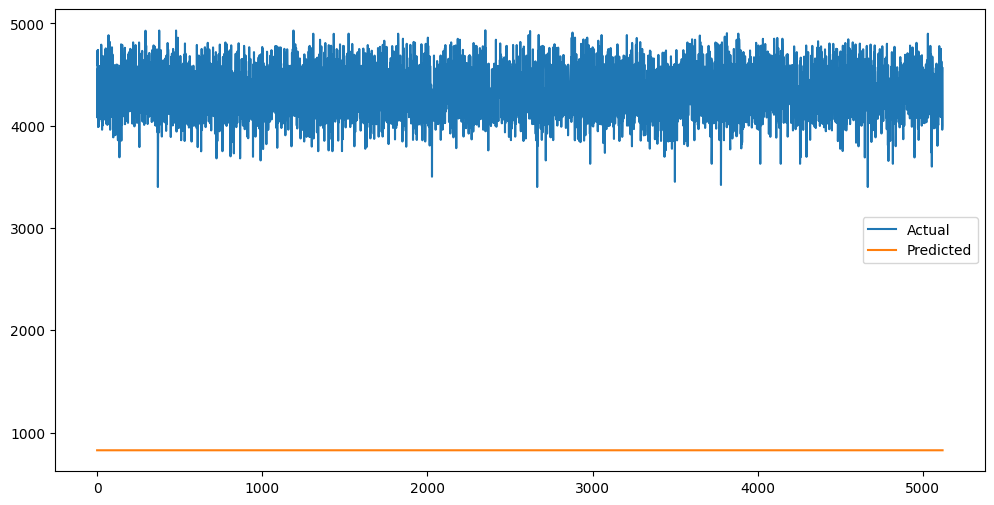

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mean Squared Error for ./../data/raw/BTCUSDT/1m\BTCUSDT_1m_99.csv: 4303694.0148
R-squared for ./../data/raw/BTCUSDT/1m\BTCUSDT_1m_99.csv: 0.9797


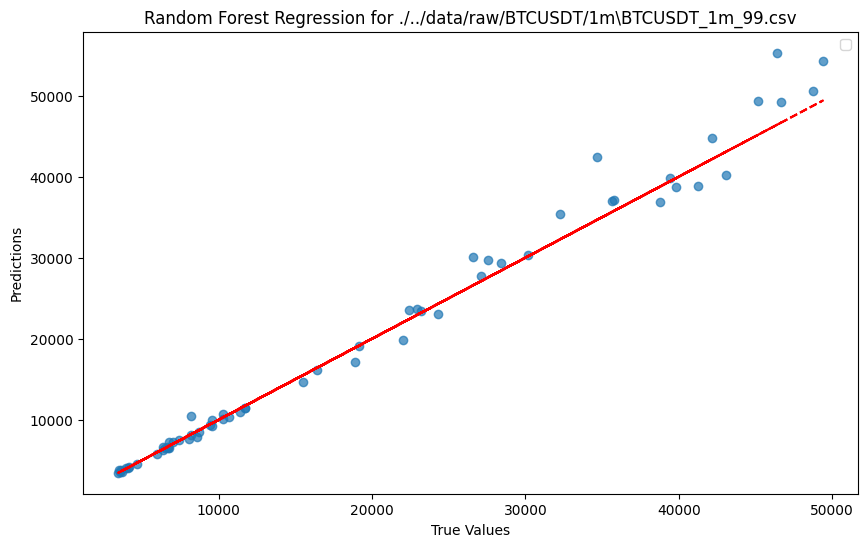

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you have a list of file paths in 'pathes'


    # Load data from the current file
data = pd.read_csv("./../data/raw/BTCUSDT/1w/BTCUSDT_1w_0.csv")

# Assuming your data has columns 'open', 'high', 'low', 'close', and 'target_column' as the target variable

# Extract features (X) and target variable (y)
X = data[['open', 'high', 'low']]
y = data['close']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest Regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error for {path}: {mse:.4f}")
print(f"R-squared for {path}: {r2:.4f}")

# Plot the results for the current file
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot(y_test, y_test, 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Random Forest Regression for {path}')
plt.legend()
plt.show()


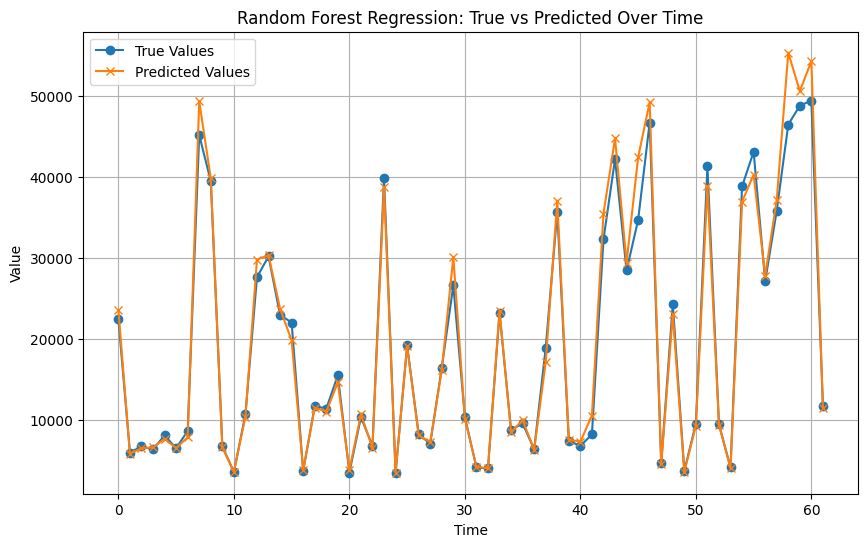

In [100]:
time = range(len(y_test))

# Plot the true and predicted values over time
plt.figure(figsize=(10, 6))
plt.plot(time, y_test, label='True Values', marker='o')
plt.plot(time, y_pred, label='Predicted Values', marker='x')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Random Forest Regression: True vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.show()

Mean Squared Error for ./../data/raw/BTCUSDT/1m\BTCUSDT_1m_99.csv: 603970.1990
R-squared for ./../data/raw/BTCUSDT/1m\BTCUSDT_1m_99.csv: 0.9975


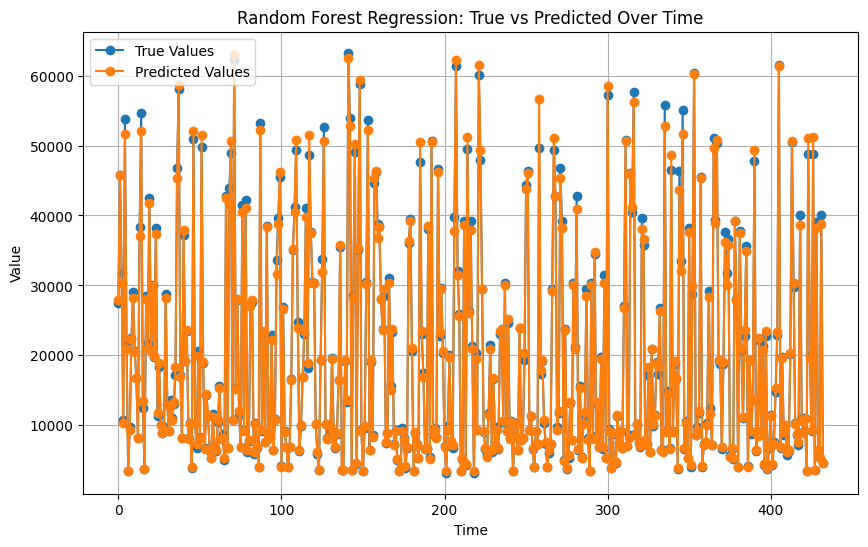

In [108]:

# Assuming you have a list of file paths in 'pathes'


    # Load data from the current file
data = pd.read_csv("./../data/raw/BTCUSDT/1d/BTCUSDT_1d_0.csv")

# Assuming your data has columns 'open', 'high', 'low', 'close', and 'target_column' as the target variable

# Extract features (X) and target variable (y)
X = data[['open', 'high', 'low']]
y = data['close']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest Regression model


# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error for {path}: {mse:.4f}")
print(f"R-squared for {path}: {r2:.4f}")

# Plot the results for the current file
time = range(len(y_test))

# Plot the true and predicted values over time
plt.figure(figsize=(10, 6))
plt.plot(time, y_test, label='True Values', marker='o')
plt.plot(time, y_pred, label='Predicted Values', marker='o')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Random Forest Regression: True vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.show()
